In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import gmaps
%matplotlib inline 

In [2]:
housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)
housing.shape

(2580, 81)

[Text(0, 0.5, 'Median Sale Price ($)'), Text(0.5, 0, 'Neighborhood')]

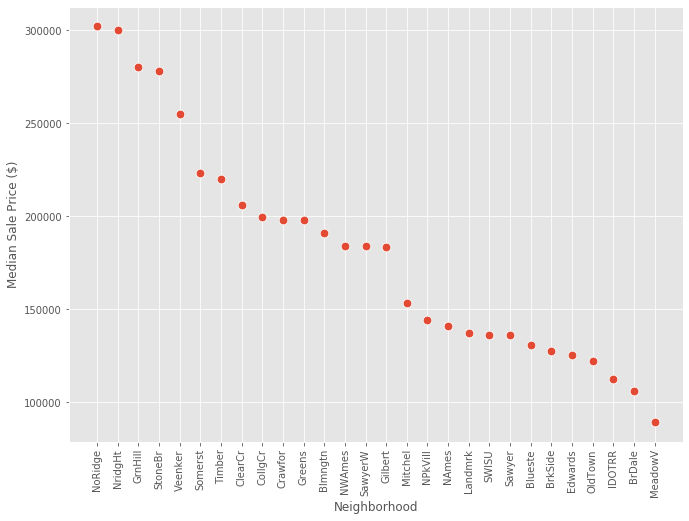

In [3]:
d_nbhd_df = housing[['Neighborhood','SalePrice']]
d_grp_df = d_nbhd_df.groupby('Neighborhood')
key_list = d_grp_df.groups.keys()
d_sum_df = pd.DataFrame(d_grp_df.median())
d_sum_df['area'] = key_list
d_sum_df = d_sum_df.sort_values('SalePrice', ascending=False)

a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.scatterplot(d_sum_df['area'], d_sum_df['SalePrice'], s=75)
plt.xticks(rotation=90)
g.set(xlabel='Neighborhood', ylabel='Median Sale Price ($)')
#figure = g.get_figure()
#g.figure.savefig("sale_price.png")

In [4]:
housing['priceperarea']=housing['SalePrice']/housing['GrLivArea']

# Extracting Latitude and Longitude Positions

In [5]:
re_data = pd.read_csv('Ames_Real_Estate_Data.csv', index_col=0)

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
data_sub = re_data[['GeoRefNo', 'Prop_Addr']].copy()

In [13]:
data_sub.rename(columns={'GeoRefNo': 'PID'}, inplace=True)

In [17]:
housing_temp = pd.merge(data_sub, housing, on='PID')
housing_temp['Latitude']= None
housing_temp['Longitude']= None

In [9]:
import geopy
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent="myGeocoder")

In [10]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=1.5)

In [ ]:
for i in range(len(housing_temp)):
    addr = housing_temp.loc[i,'Prop_Addr']
    if type(addr)==str:
        location = locator.geocode(addr+', Ames, USA')
        try:
            Temp.loc[i,'Latitude'] = location.latitude
        except: 
            Temp.loc[i,'Latitude'] = None
        try:
            Temp.loc[i,'Longitude'] = location.longitude
        except:
            Temp.loc[i,'Longitude'] = None

# Idenitfying locations of individual neighborhoods

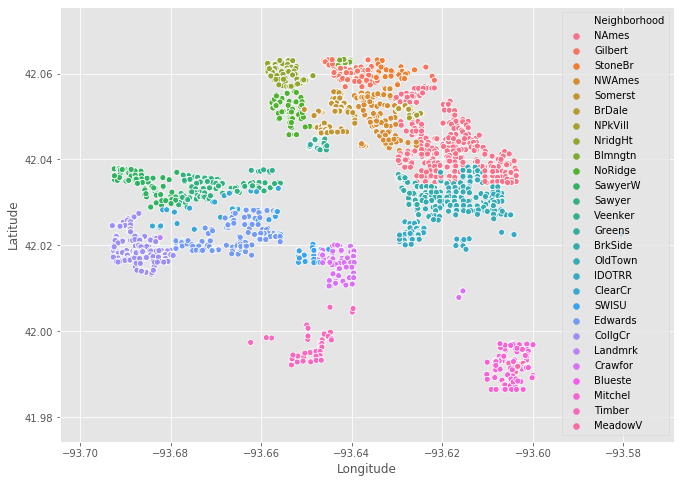

In [22]:
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Longitude', y='Latitude', data=housing_temp, hue ='Neighborhood')

[(41.98, 42.07), (-93.705, -93.57)]

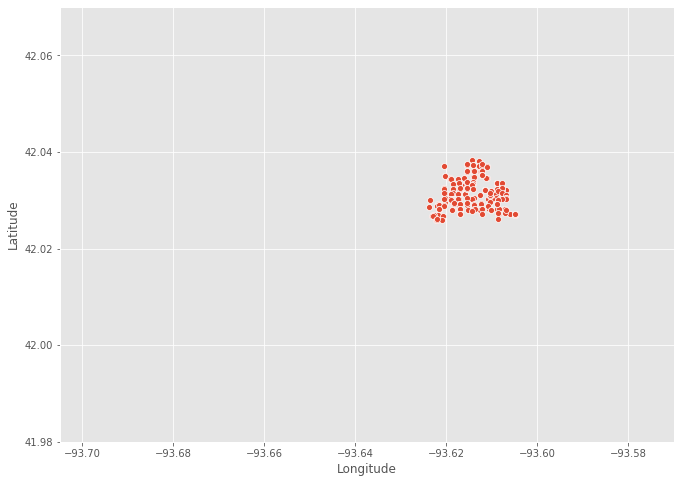

In [23]:
n_df = housing_temp.loc[housing_temp.Neighborhood=='OldTown']
#repeat this procedure for each neighborhood
a4_dims = (11, 8)
fig, ax = plt.subplots(figsize=a4_dims)
pp = sns.scatterplot(x='Longitude', y='Latitude', data=n_df)
pp.set(xlim=(-93.705, -93.57), ylim=(41.98, 42.07))

# Calculating distance from lat, long values

In [24]:
from math import radians, sin, cos, acos

In [25]:
def dfromlatlon(elat, elon, slat, slon): 
#returns distance in km between two sets of lat, long coordinates
    try:
        rslat = radians(float(slat))
    except: 
        return None
    try:
        rslon = radians(float(slon))
    except:
        return None
    try:
        relat = radians(float(elat))
    except:
        return None
    try:
        relon = radians(float(elon))
    except:
        return None
    acfac = sin(rslat)*sin(relat) + cos(rslat)*cos(relat)*cos(rslon - relon)
    if acfac >1:
        acfac =1
    if acfac < -1:
        acfac = -1
    dist = 6371.01 * acos(acfac)
    return dist

# Checking correlation of distance to various places with priceperarea

In [ ]:
#Locations of various places used for tests
AmesGC = pd.Series([42.076419, -93.656501]) #Ames Golf Club
Star1 = pd.Series([42.052843, -93.620452]) #Starbucks 1
Star2 = pd.Series([42.024044, -93.669681]) #Starbucks 2
Star3 = pd.Series([42.024555, -93.646424]) #Starbucks 3
Star4 = pd.Series([42.022526, -93.619839]) #Starbucks 4
Star5 = pd.Series([42.025714, -93.615033]) #Starbucks 5
Star6 = pd.Series([42.021634, -93.609883]) #Starbucks 6
union = pd.Series([42.024002, -93.646012]) #Student Union
acc = pd.Series([42.076470, -93.658276]) #Ames Country Club

In [ ]:
#method for calculating distance
d1 = list(map(lambda x,y: dfromlatlon(Star1[0],Star1[1],x,y), housing_temp['Latitude'], housing_temp['Longitude']))

[None]

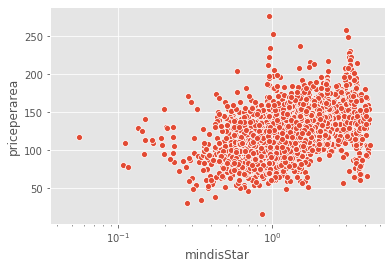

In [26]:
g = sns.scatterplot(x='mindisStar', y='priceperarea', data=housing_temp)
#mindisStar is minimum distance to Starbucks
#g.set(yscale="log")
g.set(xscale='log')

In [27]:
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

In [43]:
housing_temp2 = housing_temp[['PID', 'SalePrice', 'priceperarea','Latitude', 'Longitude', 'mindisStar']].copy().drop_duplicates(subset=['PID']).dropna().reset_index()

In [44]:
ppa = housing_temp2['priceperarea'].copy()
stard = housing_temp2[['mindisStar']].copy()
lm = LinearRegression()
lm.fit(np.log(stard), ppa)
lm.score(np.log(stard), ppa)

0.1475194541294934

# Engineering of nearest neighbor price feature

In [51]:
PID = housing_temp2['PID'].copy()
lats = housing_temp2['Latitude'].copy()
longs = housing_temp2['Longitude'].copy()
ppa = housing_temp2['priceperarea'].copy()
sp = housing_temp2['SalePrice'].copy()

In [46]:
nn5medsaleprice = []
nn5meansaleprice = []
for i in range(len(lats)):
    lat2 = lats.copy()
    long2 = longs.copy()
    lat2[i] = 45.0
    long2[i] = -95
    if (str(lats[i])=='nan'):
        nn5medsaleprice.append(lats[i])
        nn5meansaleprice.append(lats[i])        
    else:
        d_lst = list(map(lambda x,y: dfromlatlon(lats[i],longs[i],x,y), lat2, long2))
        d_lst = [d if str(d) != 'nan' else 100.0 for d in d_lst]
        tops = sorted(range(len(d_lst)), key=lambda j: d_lst[j])[:5]
        nn5medsaleprice.append(np.median(sp[tops]))
        nn5meansaleprice.append(np.mean(sp[tops]))

In [52]:
sales_df = pd.DataFrame(list(zip(PID, ppa, sp, nn5meansaleprice, nn5medsaleprice )), columns=['PID', 'priceperarea', 'SalePrice', 'nn5meansaleprice', 'nn5medsaleprice'])

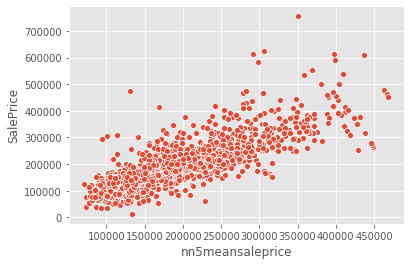

In [53]:
g = sns.scatterplot(x='nn5meansaleprice', y='SalePrice', data=sales_df)

In [55]:
lm2 = LinearRegression()
lm2.fit(sales_df[['nn5meansaleprice']], sales_df['SalePrice'])
lm2.score(sales_df[['nn5meansaleprice']], sales_df['SalePrice'])

0.6912567766210698

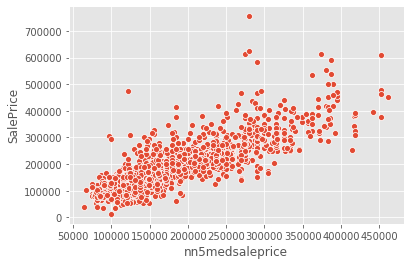

In [56]:
g = sns.scatterplot(x='nn5medsaleprice', y='SalePrice', data=sales_df)

In [57]:
lm3 = LinearRegression()
lm3.fit(sales_df[['nn5medsaleprice']], sales_df['SalePrice'])
lm3.score(sales_df[['nn5medsaleprice']], sales_df['SalePrice'])

0.68873132535821

# Creation of google maps with lat, long locations

In [58]:
gmaps.configure(api_key='insert API key here')

In [61]:
#the following code will not work without correct api_key. Image below shows the result
locations = housing_temp2[['Latitude', 'Longitude']]
weights = housing_temp2['SalePrice']
house_layer = gmaps.symbol_layer(locations, scale=1)
figure_layout = {
    'width': '800px',
    'height': '1000px',
    'border': '1px solid black',
    'padding': '1px'
}
fig= gmaps.figure(layout=figure_layout)
fig.add_layer(house_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='1000px', padding='1px', width='800px'))

<img src='lat_long_map.png' width=400 height=600 align='left'>

In [ ]:
#the following code will not work without correct api_key. Image below shows the result
bin1_layer = gmaps.symbol_layer(
    Bin1, fill_color='rgba(255, 0, 0, 1)',
    stroke_color='rgba(255, 0, 0, 1)', scale=2
)
bin2_layer = gmaps.symbol_layer(
    Bin2, fill_color='rgba(128, 128, 0, 1)',
    stroke_color='rgba(128, 128, 0, 1)', scale=2
)
bin3_layer = gmaps.symbol_layer(
    Bin3, fill_color='rgba(0, 0, 255, 1)',
    stroke_color='rgba(0, 0, 255, 1)', scale=2
)
bin4_layer = gmaps.symbol_layer(
    Bin4, fill_color='rgba(0, 128, 0, 1)',
    stroke_color='rgba(0, 128, 0, 1)', scale=2
)
bin5_layer = gmaps.symbol_layer(
    Bin5, fill_color='rgba(0, 128, 128, 1)',
    stroke_color='rgba(0, 128, 128, 1)', scale=2
)
bin6_layer = gmaps.symbol_layer(
    Bin6, fill_color='rgba(128, 0, 0, 1)',
    stroke_color='rgba(128, 0, 0, 1)', scale=2
)

figure_layout = {
    'width': '800px',
    'height': '1000px',
    'border': '1px solid black',
    'padding': '1px'
}
fig= gmaps.figure(layout=figure_layout)
fig.add_layer(bin1_layer)
fig.add_layer(bin2_layer)
fig.add_layer(bin3_layer)
fig.add_layer(bin4_layer)
fig.add_layer(bin5_layer)
fig.add_layer(bin6_layer)
fig

<img src='lat_long_w_prices.png' width=400 height=600 align='left'>